<hr style="height: 1px;">
<i>This notebook was authored by the 8.S50x Course Team, Copyright 2022 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

<h1>Lesson 24: Simulation-based (Likelihood-free) Inference</h1>


<a name='section_24_0'></a>
<hr style="height: 1px;">


## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L24.0 Overview</h2>


<h3>Navigation</h3>

<table style="width:100%">
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_24_1">L24.1 Simple bump-on-power-law example and Explicit Likelihood</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_24_1">L24.1 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_24_2">L24.2 Implicit Likelihood Method 1: Approximate Bayesian Computation</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_24_2">L24.2 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_24_3">L24.3 Implicit Likelihood Method 2: Neural Likelihood-ratio Estimation</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_24_3">L24.3 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_24_4">L24.4 Implicit Likelihood Method 3: Neural Posterior Estimation</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_24_4">L24.4 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_24_5">L24.5 A more complicated example: distribution of point sources in a 2D image</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_24_5">L24.5 Exercises</a></td>
    </tr>
</table>

<h3>Learning Objectives</h3>

Simulation-based inference (SBI) is a powerful class of methods for performing inference in settings where the likelihood is computationally intractable, but simulations can be used in order to optimize the fitting of more complex models to data. We will use the term "forward model" to indicate generating simulated data given a set of input parameters, a process which will be called "realizing" a sample. In contrast, inference is the process of finding optimal values of the parameters given a set of data, and so can be considered working the model "backwards".

In this Lesson, we will
- Introduce the notion of an implicit likelihood, and how to leverage it to perform inference;
- Look at an alternative, more "traditional" method for likelihood-free inference, Approximate Bayesian Computation (ABC);
- Consider two common modern _neural_ SBI techniques: neural likelihood-ratio estimation (NRE) and neural posterior estimation (NPE);
- Introduce the concept of statistical coverage testing and calibration.

As examples, we will look at two very different situations. The first is the case where we are looking for a new particle which, if present, will generate an excess of events (a "bump") on top of a background of other known processes. In this case, our model will be a simple Gaussian signal on top of a background assumed to be a power law distribution. For this so-called "bump hunt", calculating the likelihood is computationally tractable, so we can compare a more traditional method with the approaches required in more complex situations.

 The second example is more complicated, requiring us to model a distribution of counts over a 2D space representing the locations of point sources. Here, the likelihood is computationally intractable. We will emphasize what it means for a likelihood to be computationally intractable/challenging and where the advantages of SBI come in.


<h3>Installing Tools</h3>

Before we do anything, let's make sure we install the tools we need. Note that this is another longer-than-typical install.

In [1]:
#>>>RUN: L24.0-runcell00

!pip install --upgrade emcee corner pytorch-lightning tqdm nflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 35.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 41.8 MB/s eta 0:00:00 0:00:01
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53653 sha256=8ad50fabf65c10d8e0d12e9354d17c8e2b6f3c765d05ea301c6cd990ef68bdef
  Stored in directory: /Users/josemanuelplaza/Library/Caches/pip/wheels/11/9d/b5/5c88631a7bdb388738d147b6a28ba435ab969f25eff552f75a
Successfully built nflows

    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0


<h3>Importing Libraries</h3>

Next, run the cell below to import the relevant libraries for this notebook.

In [15]:
#>>>RUN: L24.0-runcell01

import torch                            #https://pytorch.org/docs/stable/torch.html
import torch.nn as nn                   #https://pytorch.org/docs/stable/nn.html
import torch.nn.functional as F         #https://pytorch.org/docs/stable/nn.functional.html
from torch.utils.data import TensorDataset, DataLoader, random_split  #https://pytorch.org/docs/stable/data.html
import numpy as np                      #https://numpy.org/doc/stable/
import emcee                            #https://emcee.readthedocs.io/en/stable/
from scipy.stats import poisson         #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html
from scipy.stats import chi2            #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html
from scipy.optimize import basinhopping #https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html
from tqdm import tqdm                   #https://pypi.org/project/tqdm/
import matplotlib.pyplot as plt         #https://matplotlib.org/stable/api/pyplot_summary.html#module-matplotlib.pyplot
import pytorch_lightning as pl          #https://lightning.ai/docs/pytorch/stable/
import corner                           #https://corner.readthedocs.io/en/latest/


<h3>Setting Default Figure Parameters</h3>

The following code cell sets default values for figure parameters.

In [16]:
#>>>RUN: L24.0-runcell02

#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title

<a name='section_24_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L24.1 Simple bump-on-power-law example and Explicit Likelihood</h2>  

| [Top](#section_24_0) | [Previous Section](#section_24_0) | [Exercises](#exercises_24_1) | [Next Section](#section_24_2) |


*The material in this section is discussed in the video **<a href="https://courses.mitxonline.mit.edu/learn/course/course-v1:MITxT+8.S50.3x+3T2023/block-v1:MITxT+8.S50.3x+3T2023+type@sequential+block@seq_LS24/block-v1:MITxT+8.S50.3x+3T2023+type@vertical+block@vert_LS24_vid1" target="_blank">HERE</a>.** You are encouraged to watch that video and use this notebook concurrently.*

<h3>Overview</h3>

The **likelihood function** (see below), a key component in statistical inference, represents the probability of data given model parameters, $p(x|\theta)$. However, calculating the likelihood can be challenging, especially for complex observations. This is because it involves computing the joint likelihood, $p(x, z|\theta)$, where $z$ represents other variables needed to describe the data but are not of direct interest. Integrating over the space of $z$'s can be computationally intractable. Simulation-based inference offers a set of methods to approximate this calculation.


<p align="center">
<img alt="the likelihood function" src="https://raw.githubusercontent.com/mitx-8s50/images/main/L24/likelihood.png" width="800"/>
</p>

Simulators are useful for generating observations from given parameters by sampling from the likelihood distribution, $p(x|\theta)$. **Simulation-based inference (SBI)** methods facilitate inference in the opposite direction, from observations to parameters.

<p align="center">
<img alt="simulation-based inference" src="https://raw.githubusercontent.com/mitx-8s50/images/main/L24/sbi.png" width="800"/>
</p>

Simulators excel at prediction tasks, generating data realizations through various random states. However, **simulators are poor for inference** because they require integrating over all possible intermediate latent states, which is challenging.

<p align="center">
<img alt="prediction" src="https://raw.githubusercontent.com/mitx-8s50/images/main/L24/prediction.png" width="600"/>
</p>

<p align="center">
<img alt="inference" src="https://raw.githubusercontent.com/mitx-8s50/images/main/L24/inference.png" width="600"/>
</p>



<h3>Why are cases like this interesting scientifically?</h3>

Inference from complex, high-dimensional scientific data typically makes use of "summary statistics" -- lower-dimensional versions of the data that are easier to work with.

SBI allows us to work with data and models at their full complexity.

<p align="center">
<img alt="summaries" src="https://raw.githubusercontent.com/mitx-8s50/images/main/L24/summaries.png" width="800"/>
</p>


<h3>An Example</h3>

As an initial example, consider a Gaussian signal $x_s$ parameterized by {amplitude $A_s$, mean location $\mu_s$, and standard deviation $\sigma_s$} on top of a power law background $x_b$ parameterized by {amplitude $A_b$ and power-law exponent $n_b$}. The total counts in any bin $x$ will be a Poisson distribution with a mean of $x_s+x_b$.

$$ x_b = A_b\,y^{n_b}$$

$$x_s = A_s\,\exp^{-(y - \mu_s)^2 / 2\sigma_s^2}$$

$$x \sim \mathrm{Pois}(x_b + x_s)$$

In [17]:
#>>>RUN: L24.1-runcell01

def bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b):
    """ Forward model for a Gaussian bump (amp_s, mu_s, std_s) on top of a power-law background (amp_b, exp_b).
    """
    x_b = amp_b * (y ** exp_b)  # Power-law background
    x_s = amp_s * np.exp(-((y - mu_s) ** 2) / (2 * std_s ** 2))  # Gaussian signal

    x = x_b + x_s  # Total mean signal

    return x

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected 

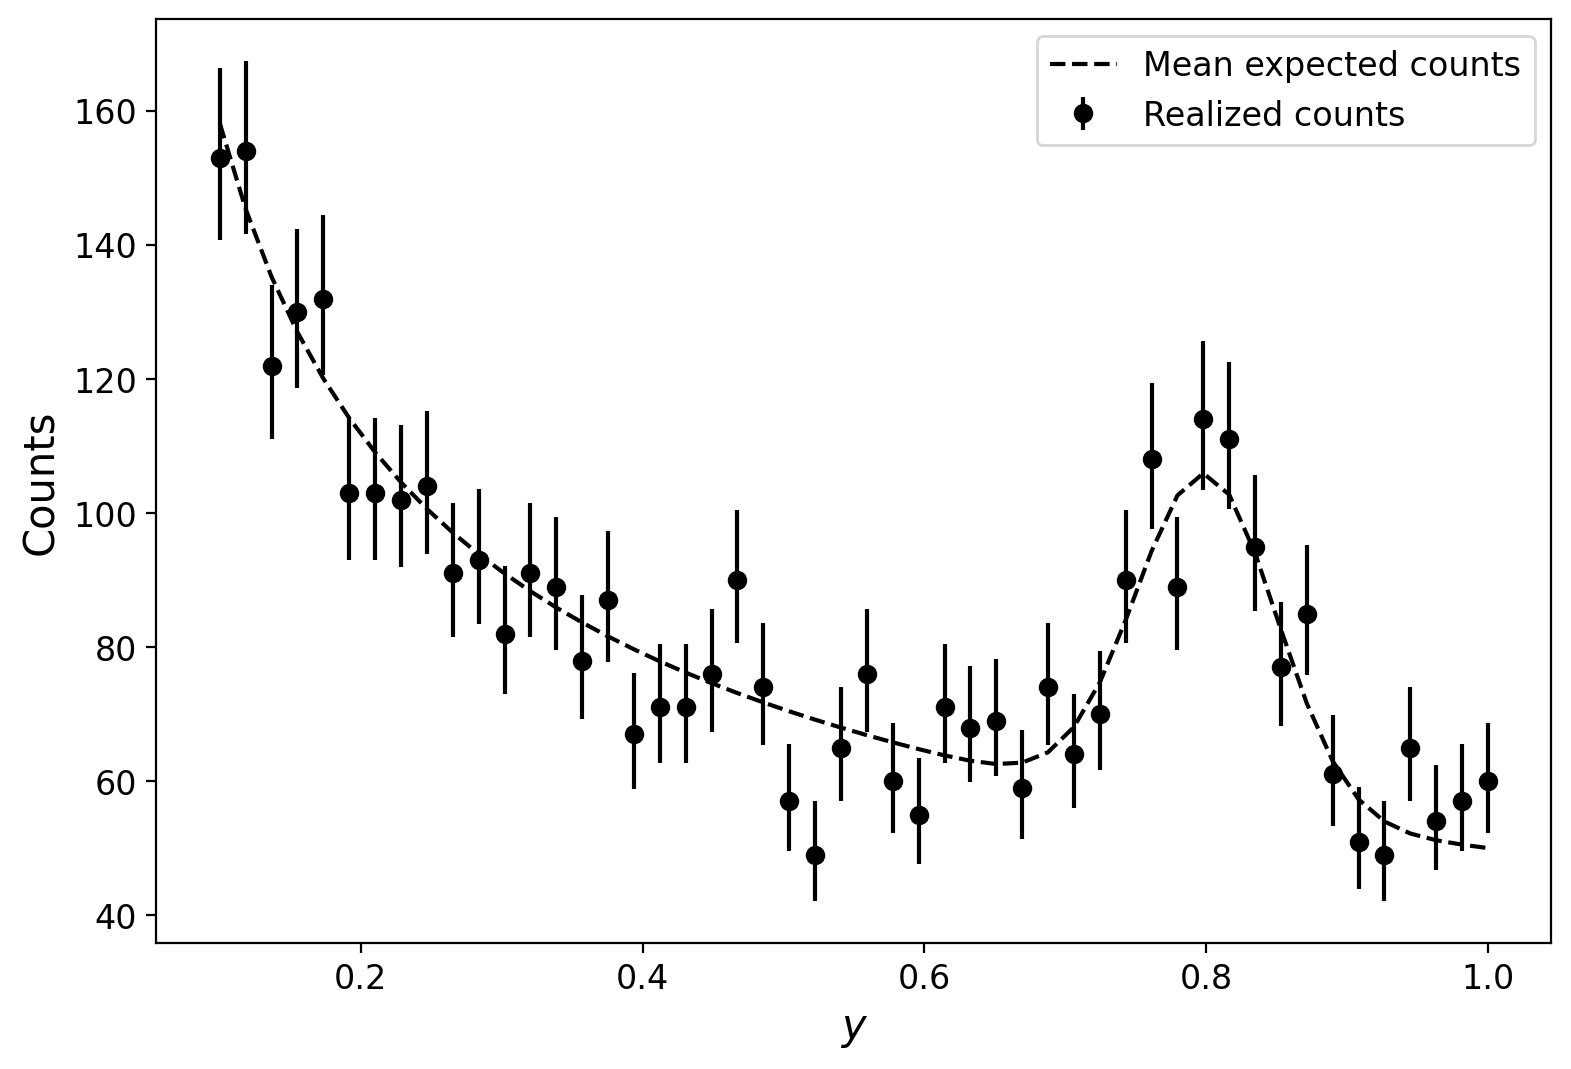

In [18]:
#>>>RUN: L24.1-runcell02

#instead of sqrt(N) uncertainties, get the full asymmetric uncertainty using a chi2
def poisson_interval(k, alpha=0.32): 
    """ Uses chi2 to get the poisson interval.
    """
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0: 
        low = 0.0
    return k - low, high - k

y = np.linspace(0.1, 1, 50)  # Dependent variable

# Mean expected counts
x_mu = bump_forward_model(y, 
                    amp_s=50, mu_s=0.8, std_s=0.05,  # Signal params
                    amp_b=50, exp_b=-0.5)  # Background params

# Realized counts
np.random.seed(42)
x = np.random.poisson(x_mu)
x_err = np.array([poisson_interval(k) for k in x.T]).T #getting asymmetric errorbars

# Plot
plt.plot(y, x_mu, color='k', ls='--', label="Mean expected counts")
plt.errorbar(y, x, yerr=x_err, fmt='o', color='k', label="Realized counts")

plt.xlabel("$y$")
plt.ylabel("Counts")

plt.legend()

<h3>The Explicit Likelihood</h3>

In this case, we can write down a log-likelihood as a Poisson with a mean $\mu$ given by the prediction returned by the forward model, evaluated at a value given by the data $x$. Here, as in the figures shown above, we use the vector `theta` ($\theta$ in the figures) to denote the set of model parameters.

In [19]:
#>>>RUN: L24.1-runcell03

def log_like(theta, y, x):
    """ Log-likehood function for a Gaussian bump (amp_s, mu_s, std_s) on top of a power-law background (amp_b, exp_b).
    """
    amp_s, mu_s, std_s, amp_b, exp_b = theta
    mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

Let's focus on just 2 parameters for simplicity, the signal amplitude and mean location. We compute the log-likelihood below, where we expect a number that is high for parameters that are compatible with the data, and low for parameters that are not compatible.

In [20]:
#>>>RUN: L24.1-runcell04

def log_like_sig(params, y, x):
    """ Log-likehood function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    amp_s, mu_s = params
    std_s, amp_b, exp_b = 0.05, 50, -0.5
    mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

log_like_sig([50, 0.8], y, x)

-178.44275030942168

Now we calculate a maximum-liklelihood estimate (MLE). Note, we want to minimize the negative log-likelihood, and we do so using the *basinhopping algorithm*. Basin-hoppig is an alternative approach to gradient descent. Like MCMC appraochs, it does not compute gradients rather it randomly samples points until the lowest negative log-likelihood is found.

In [21]:
#>>>RUN: L24.1-runcell05

# Initial guess for the parameters
initial_guess = [100., 0.1]

# Set up the minimizer_kwargs for the basinhopping algorithm
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": ((0, 200), (0, 1))}

# Perform the optimization using basinhopping
opt = basinhopping(lambda thetas: -log_like_sig(thetas, y, x), initial_guess, minimizer_kwargs=minimizer_kwargs)

print("MLE parameters: {}; true parameters: {}".format(opt.x, (50, 0.8)))


MLE parameters: [53.49156979  0.79989477]; true parameters: (50, 0.8)


Then, approximate the posterior using `emcee`, a package which implements a Markov Chain Monte Carlo (MCMC) procedure.

Recall Bayes' theorem:

$$ p(\theta\mid x) = \frac{p(x\mid\theta)\,p(\theta)}{p(x)}$$

With MCMC, we sample from the un-normalized posterior distribution, bypassing the need to compute the normalization $p(x)$ which is fixed for a given set of data $x$. We therefore specify the log-density $\log{p(x\mid\theta)} + \log{p(\theta)}$.


In [22]:
#>>>RUN: L24.1-runcell06

def log_prior(thetas):
    """ Log-prior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    amp_s, mu_s = thetas
    if 0 < amp_s < 200 and 0 < mu_s < 2:
        return 0
    else:
        return -np.inf
    
def log_post(thetas, y, x):
    """ Log-posterior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    lp = log_prior(thetas)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like_sig(thetas, y, x)
    
# Sampling with `emcee`
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(y, x))

pos = opt.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

100%|█████████████████████████████████████| 5000/5000 [00:04<00:00, 1092.51it/s]


To examine the results of our analysis, and compare with the true values, the following code cell generates a **corner plot**. Corner plots, which we've seen in previous lessons, are used to visualize the posterior distributions of parameters and their correlations. Specifically, the following plot shows:

- the "true" input values used to generate the data, represented by the lines as $A_s=50$ and $\mu_s=0.80$
- 1D histograms corresponding to the marginal distributions of each parameter: $A_s$ (`amp_s`) and $\mu_s$ (`mu_s`)
- a 2D pontour plot showing the joint distributions between the parameters $A_s$ and $\mu_s$
- note, the 2D contour plots includes confidence intervals (68%, 95%, and 99% levels) to indicate the density of the parameter combinations

As you can see, the position of the peak is matched very closely, but the inferred amplitude is off by about 7%. Also note that the contours in the 2D plot are very close to circular. This means that the amplitude and mean are largely uncorrelated when fitting the model parameters.

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected 

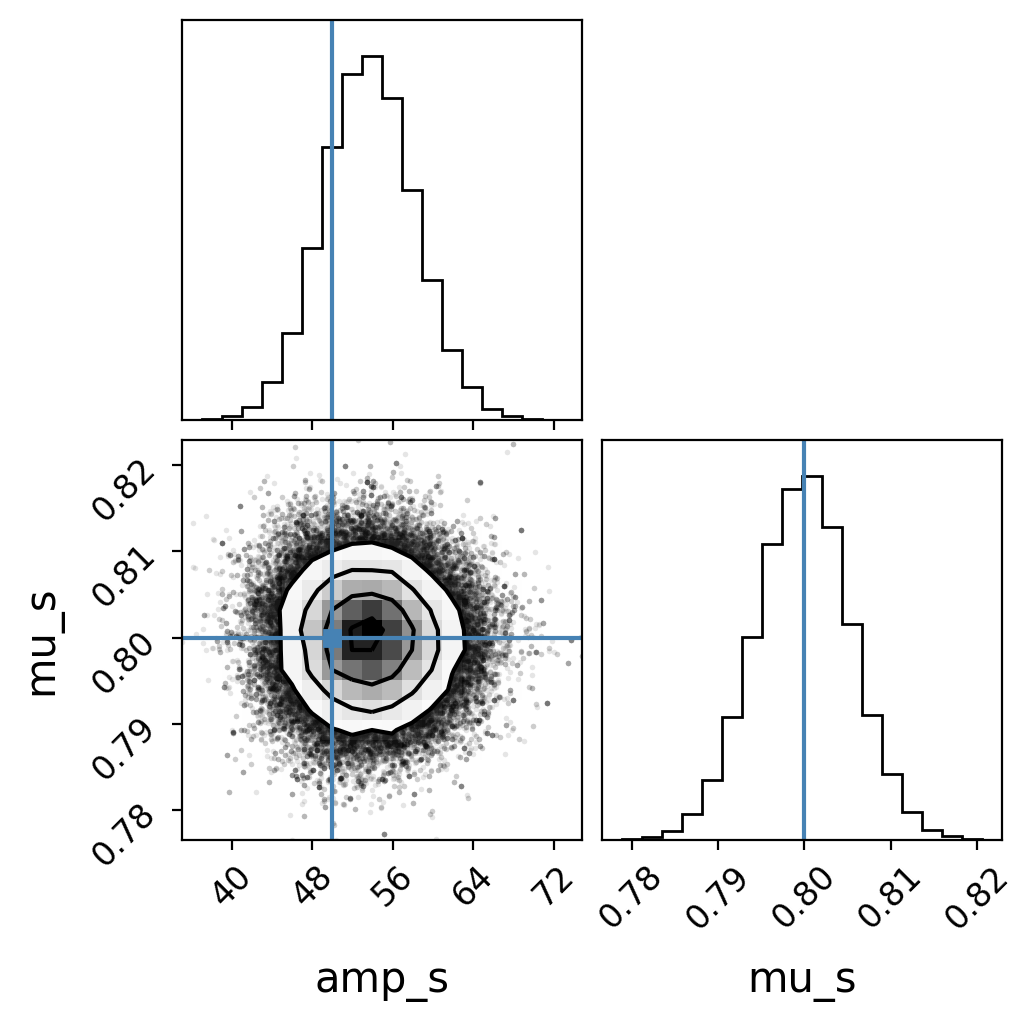

In [24]:
#>>>RUN: L24.1-runcell07

# Plot posterior samples
flat_samples = sampler.get_chain(discard=1000, flat=True)

#make the corner plot with true values as lines
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[50, 0.8], smooth=.1);


<a name='exercises_24_1'></a>     

| [Top](#section_24_0) | [Restart Section](#section_24_1) | [Next Section](#section_24_2) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 24.1.1</span>

The calculations in this section only inferred two of the signal parameters, $A_s$ (`amp_s`) and $\mu_s$ (`mu_s`). Complete the code below to also infer $\sigma_s$ (`std_s`) via likelihood maximization (negative log-likelihood minimization). Report your result for the value of $\sigma_s$ as a number with precision `1e-4`.

<br>

In [25]:
#>>>EXERCISE: L24.1.1

def log_like_sig2(params, y, x):
    #Log-likehood function for a Gaussian bump (amp_s, mu_s, std_s) on top of a fixed PL background.
    
    #YOUR CODE HERE: make std_s one of the params
    amp_s, mu_s, std_s = params
    amp_b, exp_b, = 50, -0.5
    mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()


# Initial guess for the parameters
initial_guess = [100., 0.1, 0.01]

# Set up the minimizer_kwargs for the basinhopping algorithm
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": ((0, 200), (0, 1), (0.001, .2))}

# Perform the optimization using basinhopping
opt2 = basinhopping(lambda thetas: -log_like_sig2(thetas, y, x), initial_guess, minimizer_kwargs=minimizer_kwargs)

print("MLE parameters: {}; true parameters: {}".format(opt2.x, (50, 0.8, 0.05)))

MLE parameters: [5.31139563e+01 7.99860190e-01 5.06056103e-02]; true parameters: (50, 0.8, 0.05)


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 24.1.2</span>

Now generate the posterior distributions by running MCMC on the 3 parameters, as we did above for the two parameters. Make a corner plot, as done at the end of this section. Which parameters appear to be correlated?

A) `amp_s` and `mu_s`

B) `amp_s` and `std_s`

C) `mu_s` and `std_s`

<br>

In [26]:
#>>>EXERCISE: L24.1.2

def log_prior2(thetas):
    #Log-prior function for a Gaussian bump (amp_s, mu_s, std_s) on top of a fixed PL background.
    
    #YOUR CODE HERE
    amp_s, mu_s, std_s = thetas
    if 0 < amp_s < 200 and 0 < mu_s < 2 and 0 < std_s < 0.5:
        return 0
    else:
        return -np.inf

def log_post2(thetas, y, x):
    #Log-posterior function for a Gaussian bump (amp_s, mu_s, std_s) on top of a fixed PL background.
    
    lp = log_prior2(thetas)
    if not np.isinfinite(lp):
        return -np.inf
    else:
        return lp + log_like_sig2(thetas, y, x)
    
# Sampling with `emcee`
ndim, nwalkers = 3, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post2, args=(y, x))

# using basinhopping optimization from EXERCISE: L24.1.1 (i.e., opt2)
pos = opt2.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

# Plot posterior samples
#YOUR CODE HERE

emcee: Exception while calling your likelihood function:
  params: [5.31134336e+01 8.00909199e-01 4.99012666e-02]
  args: (array([0.1       , 0.11836735, 0.13673469, 0.15510204, 0.17346939,
       0.19183673, 0.21020408, 0.22857143, 0.24693878, 0.26530612,
       0.28367347, 0.30204082, 0.32040816, 0.33877551, 0.35714286,
       0.3755102 , 0.39387755, 0.4122449 , 0.43061224, 0.44897959,
       0.46734694, 0.48571429, 0.50408163, 0.52244898, 0.54081633,
       0.55918367, 0.57755102, 0.59591837, 0.61428571, 0.63265306,
       0.65102041, 0.66938776, 0.6877551 , 0.70612245, 0.7244898 ,
       0.74285714, 0.76122449, 0.77959184, 0.79795918, 0.81632653,
       0.83469388, 0.85306122, 0.87142857, 0.88979592, 0.90816327,
       0.92653061, 0.94489796, 0.96326531, 0.98163265, 1.        ]), array([153, 154, 122, 130, 132, 103, 103, 102, 104,  91,  93,  82,  91,
        89,  78,  87,  67,  71,  71,  76,  90,  74,  57,  49,  65,  76,
        60,  55,  71,  68,  69,  59,  74,  64,  70,  90, 108,

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/3b/srf3cvtx1418sl6pv5bkm8cc0000gn/T/ipykernel_33625/1044935388.py", line 17, in log_post2
    if not np.isinfinite(lp):
           ^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/numpy/__init__.py", line 333, in __getattr__
    raise AttributeError("module {!r} has no attribute "
AttributeError: module 'numpy' has no attribute 'isinfinite'


AttributeError: module 'numpy' has no attribute 'isinfinite'

<a name='section_24_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L24.2 Implicit Likelihood Method 1: Approximate Bayesian Computation</h2>  

| [Top](#section_24_0) | [Previous Section](#section_24_1) | [Exercises](#exercises_24_2) | [Next Section](#section_24_3) |


*The material in this section is discussed in the video **<a href="https://courses.mitxonline.mit.edu/learn/course/course-v1:MITxT+8.S50.3x+3T2023/block-v1:MITxT+8.S50.3x+3T2023+type@sequential+block@seq_LS24/block-v1:MITxT+8.S50.3x+3T2023+type@vertical+block@vert_LS24_vid2" target="_blank">HERE</a>.** You are encouraged to watch that video and use this notebook concurrently.*

<h3>Overview</h3>

Now, we will preform the inference again, but this time without relying on the explicit likelihood evaluation. The key realization is that samples from the forward model implicitly encode the likelihood; when we are simulating data points $x$ for different parameter points $\theta$, we are drawing samples from the likelihood:

$$x\sim p(x\mid\theta)$$

which is where the _implicit_ aspect comes from. Let's write down a bump simulator:

In [27]:
#>>>RUN: L24.2-runcell01

def bump_simulator(thetas, y):
    """ Simulate samples from the bump forward model given theta = (amp_s, mu_s) and abscissa points y.
    """
    amp_s, mu_s = thetas
    std_s, amp_b, exp_b = 0.05, 50, -0.5
    x_mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    x = np.random.poisson(x_mu)
    return x

#we had defined this funciton previously
def bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b):
    """ Forward model for a Gaussian bump (amp_s, mu_s, std_s) on top of a power-law background (amp_b, exp_b).
    """
    x_b = amp_b * (y ** exp_b)  # Power-law background
    x_s = amp_s * np.exp(-((y - mu_s) ** 2) / (2 * std_s ** 2))  # Gaussian signal

    x = x_b + x_s  # Total mean signal

    return x

# Test it out
y = np.linspace(0.1, 1, 50)
bump_simulator([50, 0.8], y)

array([180, 171, 150, 121, 111,  95, 104,  85, 102,  92, 108,  83, 101,
        98, 102,  89,  79,  85,  74,  67,  69,  66,  50,  66,  75,  65,
        83,  67,  80,  65,  56,  56,  71,  65,  80,  93,  86, 105,  98,
       115,  98,  68,  68,  68,  44,  58,  61,  51,  58,  54])

<h3>Approximate Bayesian Computation (ABC)</h3>

The idea behind Approximate Bayesian Computation (ABC) is to realize samples from the forward model (with the parameters $\theta$ drawn from a prior) and compare it to the dataset of interest $x$. If the data and realized samples are close enough to each other according to some criterion, we keep the parameter points.

<p align="center">
<img alt="approximate bayesian computation" src="https://raw.githubusercontent.com/mitx-8s50/images/main/L24/abc.png" width="800"/>
</p>

The comparison criterion here is a simple mean squares error (MSE, denoted `eps` in the code shown below) between the data points and the output of the forward model with a given set of parameters. Play around with the parameters of the forward model (the inputs to the forward model are initially set to 50 and 0.8) to see how the criterion `eps` changes. You can also try simply rerunning code cell `L24.2-runcell03` repeatedly to see how the MSE changes for different independently realized samples.

In [28]:
#>>>RUN: L24.2-runcell02

#define the simulated data again, if you have not done so in the previous section

def poisson_interval(k, alpha=0.32): 
    """ Uses chi2 to get the poisson interval.
    """
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0: 
        low = 0.0
    return k - low, high - k

# Mean expected counts
x_mu = bump_forward_model(y, 
                    amp_s=50, mu_s=0.8, std_s=0.05,  # Signal params
                    amp_b=50, exp_b=-0.5)  # Background params

# Realized counts
np.random.seed(42)
x = np.random.poisson(x_mu)
x_err = np.array([poisson_interval(k) for k in x.T]).T

In [29]:
#>>>RUN: L24.2-runcell03

x_fwd = bump_simulator([50, 0.8], y)
eps = np.sum(np.abs(x - x_fwd) ** 2) / len(x)
eps

180.82

<h3>Implementing the ABC Procedure</h3>

Code cell `L24.2-runcell04` implements the ABC procedure by generating a lot of such independent samples, keeping ones that have an MSE below a specified threshold.

Code cell `L24.2-runcell05` displays similar posterior distributions as were shown above. Specifically, the red distribution represents the MCMC results from before (narrower), while the black distribution shows the approximate posterior using ABC (broader). The ABC posterior roughly captures the central value but is more conservative, which is expected since it's based on simulations and isn't a highly precise method.

Finally, note that the change of axes scales means that the contours are ovals instead of circles, but the lack of any tilt of these contours means that once again the probabilities for the amplitude and mean are independent.

In [30]:
#>>>RUN: L24.2-runcell04

def abc(y, x, eps_thresh=500., n_samples=1000):
    """ABC algorithm for Gaussian bump model.

    Args:
        y (np.ndarray): Abscissa points.
        x (np.ndarray): Data counts.
        eps_thresh (float, optional): Acceptance threshold. Defaults to 500.0.
        n_samples (int, optional): Number of samples after which to stop. Defaults to 1000.

    Returns:
        np.ndarray: Accepted samples approximating the posterior p(theta|x).
    """
    samples = []
    total_attempts = 0
    progress_bar = tqdm(total=n_samples, desc="Accepted Samples", unit="samples")

    # Keep simulating until we have enough accepted samples
    while len(samples) < n_samples:
        params = np.random.uniform(low=[0, 0], high=[200, 1])  # Priors; theta ~ p(theta)
        x_fwd = bump_simulator(params, y)  # x ~ p(x|theta)
        eps = np.sum(np.abs(x - x_fwd) ** 2) / len(x)  # Distance metric; d(x, x_fwd)
        total_attempts += 1

        # If accepted, add to samples
        if eps < eps_thresh:
            samples.append(params)
            progress_bar.update(1)
            acceptance_ratio = len(samples) / total_attempts
            progress_bar.set_postfix(acceptance_ratio=f"{acceptance_ratio:.3f}")

    progress_bar.close()
    return np.array(samples)

n_samples = 5_000
post_samples = abc(y, x, eps_thresh=200, n_samples=n_samples)

Accepted Samples: 100%|█| 5000/5000 [00:13<00:00, 382.87samples/s, acceptance_ra


/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected 

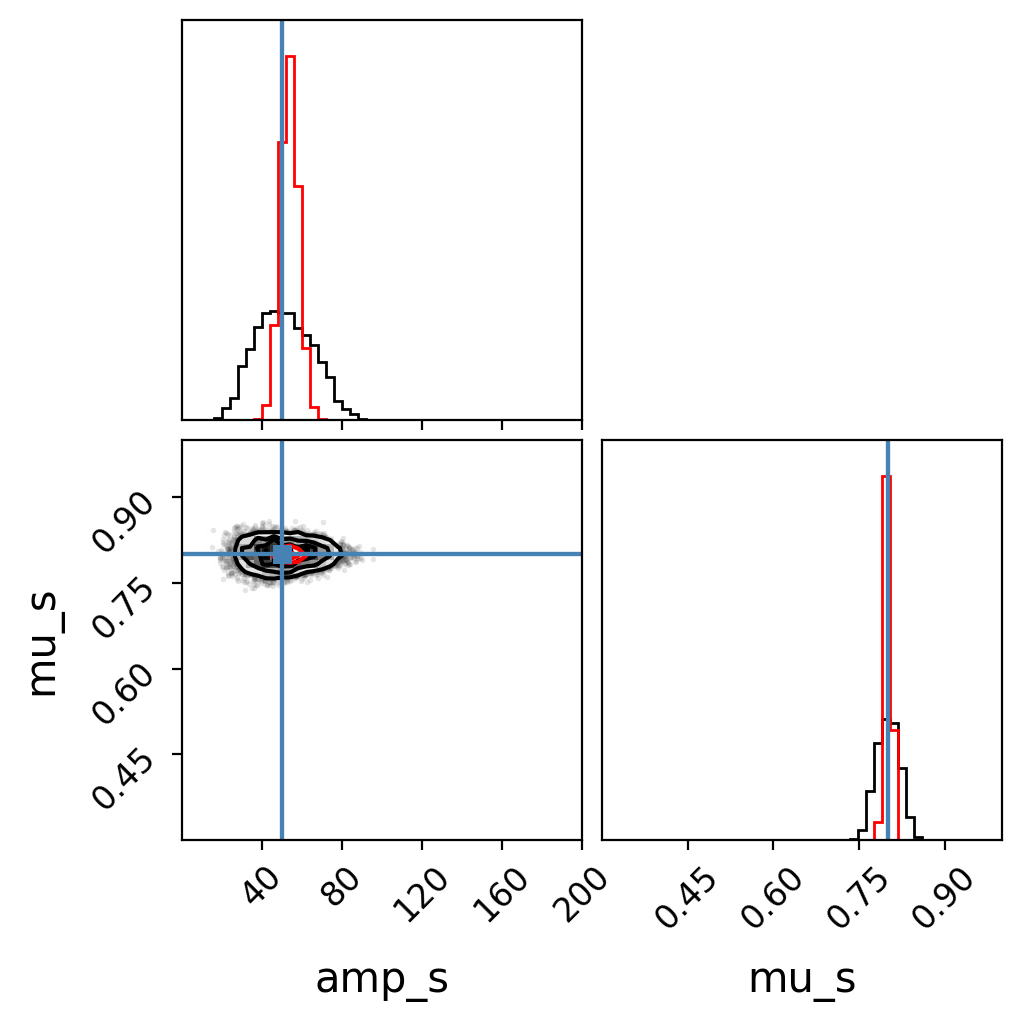

In [31]:
#>>>RUN: L24.2-runcell05

#note: here we also plot `flat_samples`, which was defined in cell `L24.1-runcell07`
fig = corner.corner(post_samples, labels=["amp_s", "mu_s"], truths=[50, 0.8], range=[(0, 200), (0.3, 1)], bins=50);
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[50, 0.8], fig=fig, color="red", weights=np.ones(len(flat_samples)) * n_samples / len(flat_samples), range=[(0, 200), (0.3, 1)], bins=50);

<h3>Downsides</h3>

Downsides of basic, plain vanilla, ABC:
- ABC works well for low-dimensional data, but this raises the question "How to summarize the data?". And when reducing dimensionality, we inherently lose information.
- Since there is no likelihood, comparison with data can be made through MSE, but can also be done other ways (some better or worse).
- Choosing an exception threshold (epsilon) is tricky—it must be small enough to be meaningful but not too small, or the process will take too long.
- The process needs to be repeated for each new dataset or prior. 

<a name='exercises_24_2'></a>     

| [Top](#section_24_0) | [Restart Section](#section_24_2) | [Next Section](#section_24_3) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 24.2.1</span>

We can attempt to use our knowledge of MSE to yield a more biased approach to finding the best fit parameters. What we can do is weight the parameers by `1./eps`. Thus, larger values of `eps`, that are closer to acceptance threshold, will be weighted LESS. Complete the code below in order to make corner plots. What happens to the best fit parameters?

A) The algorithm finds the same best fit parameters.\
B) The algorithm cannot find the best fit parameters.\
C) The algorithm finds a narrower range for `amp_s` than `mu_s`.\
D) The algorithm finds a narrower range for `mu_s` than `amp_s`.

<br>

In [33]:
#>>>EXERCISE: L24.2.1

def abc_weight(y, x, n_samples=1000,eps_thresh=500):
    #ABC algorithm for Gaussian bump model.
    #
    #Args:
    #    y (np.ndarray): Abscissa points.
    #    x (np.ndarray): Data counts.
    #    eps_thresh (float, optional): Acceptance threshold. Defaults to 500.0.
    #    n_samples (int, optional): Number of samples after which to stop. Defaults to 1000.
    #
    #Returns:
    #    np.ndarray: Accepted samples approximating the posterior p(theta|x).

    samples = []
    weights = []
    total_attempts = 0
    progress_bar = tqdm(total=n_samples, desc="Accepted Samples", unit="samples")

    # Keep simulating until we have enough accepted samples
    while len(samples) < n_samples:
        params = np.random.uniform(low=[0, 0], high=[200, 1])  # Priors; theta ~ p(theta)
        x_fwd = bump_simulator(params, y)  # x ~ p(x|theta)
        eps = np.sum(np.abs(x - x_fwd) ** 2) / len(x)  # Distance metric; d(x, x_fwd)
        total_attempts += 1

        # If accepted, add to samples
        if eps < eps_thresh:
            samples.append(params)
            weights.append(#YOUR CODE HERE) #choose weights proportional to 1/eps
            progress_bar.update(1)
            acceptance_ratio = len(samples) / total_attempts
            progress_bar.set_postfix(acceptance_ratio=f"{acceptance_ratio:.3f}")

    progress_bar.close()
    return np.array(samples), np.array(weights)*len(samples)/np.sum(weights)

n_samples = 5_000
post_samples_weight,sample_weights = abc_weight(y, x, n_samples=n_samples)

fig = corner.corner(post_samples_weight,weights=sample_weights, labels=["amp_s", "mu_s"], truths=[50, 0.8], range=[(0, 200), (0.3, 1)], bins=50);
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[50, 0.8], fig=fig, color="red", weights=np.ones(len(flat_samples)) * n_samples / len(flat_samples), range=[(0, 200), (0.3, 1)], bins=50);


SyntaxError: '(' was never closed (3589674657.py, line 30)

<a name='section_24_3'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L24.3 Implicit Likelihood Method 2: Neural Likelihood-ratio Estimation</h2>  

| [Top](#section_24_0) | [Previous Section](#section_24_2) | [Exercises](#exercises_24_3) | [Next Section](#section_24_4) |


<h3>Neural Likelihood-ratio Estimation (NRE)</h3>

Neural likelihood-ratio estimation uses a "likelihood-ratio trick" to convert a classifier into a likelihood ratio, which is widely useful, especially in fields like high-energy physics and cosmology. The classifier assigns a decision function (a confidence score between 0 and 1) that corresponds to the likelihood ratio between two classes (e.g., cat vs. bunny).

For parameter estimation, where parameters are continuous, the classifier can be parameterized with these continuous values, allowing it to output a likelihood ratio. To simplify and stabilize the process, the denominator hypothesis can be defined as a marginal, leading to a likelihood-to-evidence ratio, which will be described more below.

<p align="center">
<img alt="neural likelihood-ratio estimation" src="https://raw.githubusercontent.com/mitx-8s50/images/main/L24/nre.png" width="800"/>
</p>

For numerical stability, the alternate hypothesis $\theta_0$ can be assumed to be one where $x$ and $\theta$ are not correlated, i.e., drawn from the individual marginal distributions $\{x, \theta\} \sim p(x)\,p(\theta)$. Then, the alternate has support over the entire parameter space, instead of being a single hypothesis $\theta_0$.

In this case, we get the likelihood-to-evidence ratio,

$$\hat r(x, \theta) = \frac{s(x, \theta)}{1 - s(x, \theta)} = \frac{p(x,\theta)}{p(x)p(\theta)} = \frac{p(x\mid\theta)}{p(x)}$$

Let's further define this in the language of machine learning. The expression $\hat{r}(x, \theta)$ is known as the **classifier logit**, which is the raw output of a classifier. This raw output is converted to a probability by a **softmax function**. After applying softmax, the **decision function** yields values between 0 and 1, indicating the likelihood of a given input belonging to a certain class.



<h3>Implementing NRE</h3>

Start by creating some training data. We will uniformly sample parameters like we did in the last section. Thene we will generate toy data using these specificied samples and poisson fluctuating them. Our resuintg samples, will be the data from each bin, lets print out a few on the way.


In [50]:
#>>>RUN: L24.3-runcell01

n_train = 50_000

# Simulate training data
theta_samples = np.random.uniform(low=[0, 0], high=[200, 1], size=(n_train, 2))  # Parameter proposal
x_samples = np.array([bump_simulator(theta, y) for theta in tqdm(theta_samples)])
print("here is one set of random data poitns:",x_samples[0])

# Convert to torch tensors
theta_samples = torch.tensor(theta_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

# Normalize the data to make the NN understand these guys
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std

100%|██████████████████████████████████| 50000/50000 [00:00<00:00, 73443.35it/s]


here is one set of random data poitns: [169 143 157 114 117 131  91 101 100  97  98  97 102 110  79  66  92  80
  89  73  69  62  77  70  75  70  57  54  74  37  71  48  55  58  74  63
  70  60  75  93  85  81  67  70  73  65  46  50  50  42]


As our parameterized classifier, we will use a simple MLP (Multilayer Perceptron) neural network.

In [51]:
#>>>RUN: L24.3-runcell02

def build_mlp(input_dim, hidden_dim, output_dim, layers, activation=nn.GELU()):
    """Create an MLP from the configuration."""
    seq = [nn.Linear(input_dim, hidden_dim), activation]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation]
    seq += [nn.Linear(hidden_dim, output_dim)]
    return nn.Sequential(*seq)

Now we will create a neural ratio estimator class, with a corresponding loss function. The goal is to estimate the likelihood ratio between two distributions using a neural network. What we will want to do then is define a good paring

 * parameters $\theta_i$ correspond to the correct distribution $p_i(x)$

and a bad pairing

 * parameters $\theta_j$ correspond to the an incorrect distribution $p_i(x)$, which we define by taking our sampled histogram $p_i(x)$ and randomly pointing it to a different set of parameters $\theta_j$ such that $\theta_j\neq\theta_{i}$, ie the parameters $\theta_j$ cannot be used to generate the correct histogram

We can also just phrase this by noting that in order to discriminate between samples that are drawn from a joint distribution $\{x, \theta\} \sim p(x\mid\theta)$ and those from a product of marginals $\{x, \theta\} \sim p(x)\,p(\theta)$. In the first $p(x)$ is conditioned on $\theta$, in the later there is no defined conidtioning.

By setting up this pairing, we discriminate the correct pairing of a histogram $p(x)$ to its underlying fit parameter $\theta$.

For the training, to obtain samples from the joint distribution, we draw pairs $(x, \theta)$ from the true model, where $x$ is generated based on $\theta$. To obtain samples from incorrect pairing (ie the product of marginals) we shuffle the joint samples within a batch, breaking the conditioning between $x$ on $\theta$.

The binary cross-entropy (a common loss function) is used as the classifier loss to distinguish samples from the correct conditioning to the incorrect,

$$ L = - \sum_i y_i \log(p_i)$$

where $y_i$ are the true labels and $p_i$ the softmaxxed probabilities (i.e, values between 0 and 1).

Lets spell out our loss very clearly below.

In [52]:
#>>>RUN: L24.3-runcell03

class NeuralRatioEstimator(pl.LightningModule):
    """ Simple neural likelihood-to-evidence ratio estimator, using an MLP as a parameterized classifier.
    """
    def __init__(self, x_dim, theta_dim):
        super().__init__()
        self.classifier = build_mlp(input_dim=x_dim + theta_dim, hidden_dim=128, output_dim=1, layers=4)

    def forward(self, x):
        return self.classifier(x)

    def loss(self, x, theta):
        #x is our input histogram, the first thing we do is clone it using repeat_interleave

        # Repeat x in groups of 2 along batch axis
        x = x.repeat_interleave(2, dim=0)

        #Now we need to make a random permutation of the theta parameters to make an incorrect pairing
        # Get a shuffled version of theta
        theta_shuffled = theta[torch.randperm(theta.shape[0])]

        # We insert this into our new theta array to get the correct an incorrect pairings
        # Interleave theta and shuffled theta
        theta = torch.stack([theta, theta_shuffled], dim=1).reshape(-1, theta.shape[1])

        #Now we can define what is correct, and what is not labels[1::2]=0.0, will take [1,1,1,...]=>[1,0,1,0,..]
        #(ie first is correct and 2nd is incorrect and so on)
        # Get labels; ones for pairs from joint, zeros for pairs from marginals
        labels = torch.ones(x.shape[0], device=x.device)
        labels[1::2] = 0.0

        # Pass through parameterized classifier to get logits
        # now merge the inputs to x and theta into one vecotr and apply the mlp (note self function does this)
        logits = self(torch.cat([x, theta], dim=1))
        probs = torch.sigmoid(logits).squeeze()

        #Finally binary cross entropy with our truth
        return nn.BCELoss(reduction='none')(probs, labels)


    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [53]:
#>>>RUN: L24.3-runcell04

# Lets test out the above code, by taking 64 random histograms (x_samples[:64]) and computing the loss of the MLP
# Evaluate loss; initially it should be around -log(0.5) = 0.693
nre = NeuralRatioEstimator(x_dim=50, theta_dim=2)
nre.loss(x_samples[:64], theta_samples[:64])

tensor([0.7276, 0.6598, 0.7282, 0.6592, 0.7278, 0.6597, 0.7283, 0.6593, 0.7277,
        0.6596, 0.7281, 0.6596, 0.7281, 0.6595, 0.7279, 0.6596, 0.7276, 0.6595,
        0.7277, 0.6598, 0.7281, 0.6596, 0.7275, 0.6597, 0.7285, 0.6591, 0.7278,
        0.6595, 0.7277, 0.6596, 0.7277, 0.6597, 0.7280, 0.6595, 0.7276, 0.6595,
        0.7286, 0.6589, 0.7280, 0.6596, 0.7285, 0.6589, 0.7278, 0.6595, 0.7279,
        0.6594, 0.7275, 0.6597, 0.7280, 0.6595, 0.7281, 0.6594, 0.7278, 0.6594,
        0.7277, 0.6598, 0.7276, 0.6598, 0.7277, 0.6597, 0.7280, 0.6595, 0.7280,
        0.6595, 0.7277, 0.6595, 0.7281, 0.6593, 0.7275, 0.6595, 0.7279, 0.6597,
        0.7280, 0.6596, 0.7278, 0.6595, 0.7283, 0.6594, 0.7285, 0.6591, 0.7276,
        0.6599, 0.7278, 0.6596, 0.7277, 0.6595, 0.7274, 0.6600, 0.7276, 0.6597,
        0.7275, 0.6599, 0.7273, 0.6602, 0.7280, 0.6594, 0.7280, 0.6600, 0.7272,
        0.6602, 0.7277, 0.6595, 0.7283, 0.6592, 0.7275, 0.6597, 0.7282, 0.6594,
        0.7277, 0.6597, 0.7278, 0.6600, 

With the above NRE, we are now in stage to start training our NN> We can instantiate dataloader and train. Note that the training performed by `L24.3-runcell06` takes a bit of time. Note, we are using Pytorch lighting in this lesson to make the code sleek and fast.

In [54]:
#>>>RUN: L24.3-runcell05

val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)


In [55]:
#>>>RUN: L24.3-runcell06

trainer = pl.Trainer(max_epochs=12)
trainer.fit(model=nre, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | classifier | Sequential | 73.0 K | train
--------------------------------------------------
73.0 K    Trainable params
0         Non-trainable params
73.0 K    Total params
0.292     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.


The classifier will now take in a histogram and the two theta parameters and give you an approximate likehlihood that the parameters $\theta_i$ are a better fit for $x$. In otherwords logits are now an estimator for the likelihood ratio. We can write down a log-likelihood function and use it to sample from the corresponding posterior distribution, just like before. The reason we can do this is when we run MCMC we are taking a ratio of likelihoods. We now replace that likelihood ratio with the NN approximation

$$
r = \frac{L(\theta_i|x)}{L(\theta_j|x)} \approx \frac{NN(x,\theta_i)}{NN(x,\theta_j)}
$$

In [56]:
#>>>RUN: L24.3-runcell07

def log_like(theta, x):
    """ Log-likelihood ratio estimator using trained classifier logits.
    """
    #convert to torch and normalize inputs
    x = torch.Tensor(x)
    theta = torch.Tensor(theta)

    # Normalize
    x = (x - x_mean) / x_std
    theta = (theta - theta_mean) / theta_std
    #Ensures array input is correct
    x = torch.atleast_1d(x)
    theta = torch.atleast_1d(theta)
    #now apply the NN
    return nre.classifier(torch.cat([x, theta], dim=-1)).squeeze().detach().numpy()

theta_test = np.array([90, 0.8])
x_test = bump_simulator(theta_test, y)

log_like(theta_test, x_test)

array(2.5657775, dtype=float32)

Naturally, we need to add priors to our MCMC, if we have them. Here we use our old priors.

In [57]:
#>>>RUN: L24.3-runcell08

def log_post(theta, x):
    """ Log-posterior distribution, for sampling.
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(theta, x)

Finally, we just use our NN with a nomral MCMC sampler, in this case, we sample with `emcee`:

In [58]:
#>>>RUN: L24.3-runcell09

ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x_test,))

pos = opt.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 2000, progress=True);

100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 399.99it/s]


Plot approximate posterior:

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected 

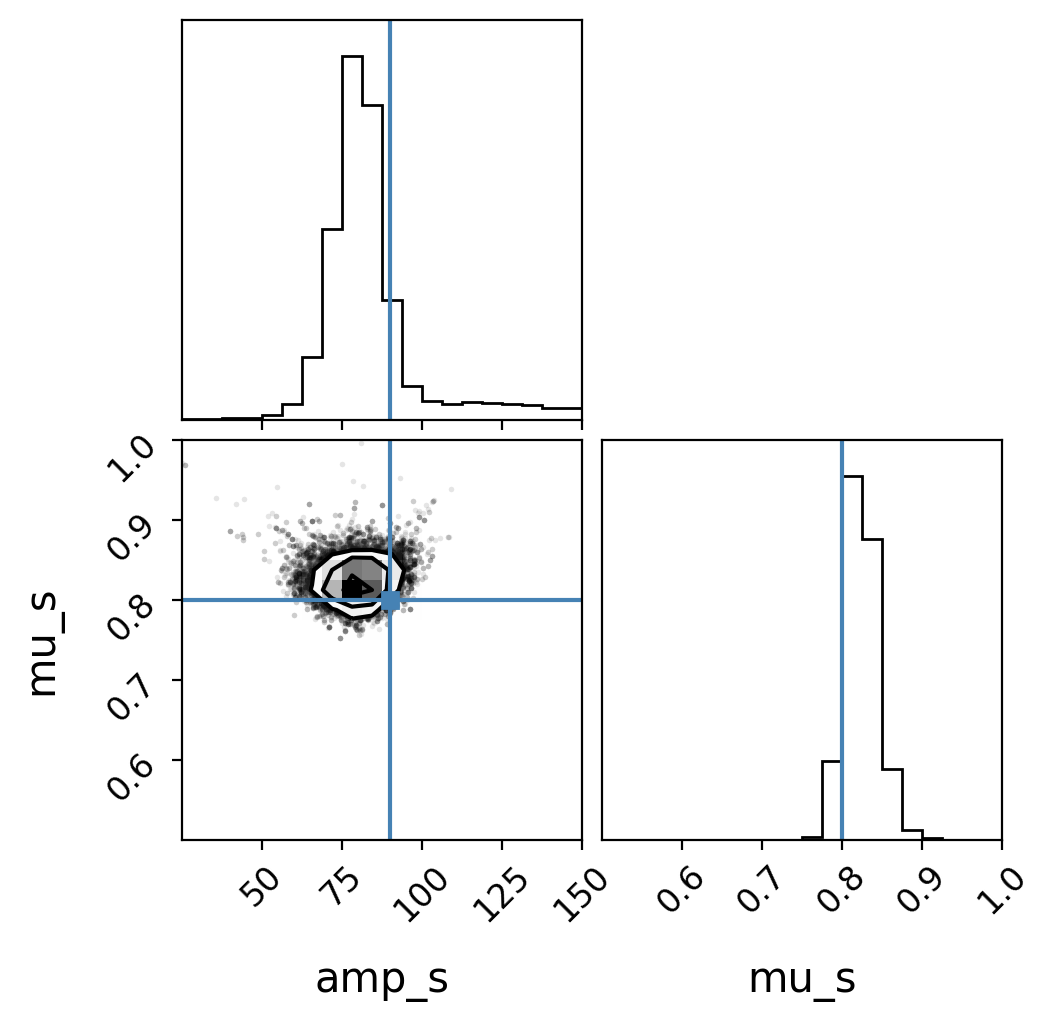

In [59]:
#>>>RUN: L24.3-runcell10

flat_samples_nre = sampler.get_chain(discard=1000, flat=True)
corner.corner(flat_samples_nre, labels=["amp_s", "mu_s"], truths=[90, 0.8], range=[(25, 150), (0.5, 1.)]);


<a name='exercises_24_3'></a>     

| [Top](#section_24_0) | [Restart Section](#section_24_3) | [Next Section](#section_24_4) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 24.3.1</span>

Complete the code below to compare the NRE approach with the previous explicit likelihood (EL) approach from section 1. How do the corner plots compare? Is one better?

A) The results are comparable with no clear winner.

B) The results are comparable, but the NRE method is better (producing a narrower range of results).

C) The results are comparable, but the EL method is better (producing a narrower range of results).


<br>

In [ ]:
#>>>EXERCISE: L24.3.1

#First create a figure with the result from `flat_samples_nre` above
fig=corner.corner(flat_samples_nre, labels=["amp_s", "mu_s"], truths=[90, 0.8], range=[(60, 120), (0.75, 0.85)]);

def log_like_sig_old(params, y, x):
    #Log-likehood function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.

    amp_s, mu_s = params
    std_s, amp_b, exp_b = 0.05, 50, -0.5
    mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

def log_post_old(thetas, y, x):
    #Log-posterior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    
    lp = log_prior(thetas)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like_sig_old(thetas, y, x)

    
# Sampling with `emcee`
## see  above, be sure to use x_test for the new x values and  log_post_old
#YOUR CODE HERE


#plot the new values from mcmc in red
flat_samples_mcmc = sampler.get_chain(discard=1000, flat=True)
corner.corner(flat_samples_mcmc,color='red', labels=["amp_s", "mu_s"], truths=[90, 0.8],fig=fig, range=[(60, 120), (0.75, 0.85)]);


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 24.3.2</span>

Now lets look into a situation where this approach starts to break down. Edit the variable `theta_samples_tmp` to set the amplitude range of our sample to be from 0 to 2000 (previously it was 0 to 200, defined earlier in this section). How does the fit look now?

A) The fit is comparable or better.

B) The fit is okay in `amp_s` but not `mu_s`.

C) The fit is okay in `mu_s` but not `amp_s`.

D) The fit is way off in both `amp_s` and `mu_s`.


<br>

In [ ]:
#>>>EXERCISE: L24.3.2

n_train = 50_000

# Simulate training data
theta_samples_tmp = np.random.uniform(####YOUR CODE HERE####)  # Parameter proposal
x_samples_tmp = np.array([bump_simulator(theta, y) for theta in tqdm(theta_samples_tmp)])

# Convert to torch tensors
theta_samples_tmp = torch.tensor(theta_samples_tmp, dtype=torch.float32)
x_samples_tmp = torch.tensor(x_samples_tmp, dtype=torch.float32)

# Normalize the data
x_mean_tmp = x_samples_tmp.mean(dim=0)
x_std_tmp = x_samples_tmp.std(dim=0)
x_samples_tmp = (x_samples_tmp - x_mean_tmp) / x_std_tmp
theta_mean_tmp = theta_samples_tmp.mean(dim=0)
theta_std_tmp = theta_samples_tmp.std(dim=0)
theta_samples_tmp = (theta_samples_tmp - theta_mean_tmp) / theta_std_tmp

#training code
val_fraction = 0.1
batch_size = 128
n_samples_val_tmp = int(val_fraction * len(x_samples_tmp))
dataset_tmp = TensorDataset(x_samples_tmp, theta_samples_tmp)
dataset_train_tmp, dataset_val_tmp = random_split(dataset_tmp, [len(x_samples_tmp) - n_samples_val_tmp, n_samples_val_tmp])
train_loader_tmp = DataLoader(dataset_train_tmp, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader_tmp = DataLoader(dataset_val_tmp, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)#

nre_largesample = NeuralRatioEstimator(x_dim=50, theta_dim=2)
trainer = pl.Trainer(max_epochs=12)
trainer.fit(model=nre_largesample, train_dataloaders=train_loader_tmp, val_dataloaders=val_loader_tmp);

def log_like(theta, x):
    """ Log-likelihood ratio estimator using trained classifier logits.
    """

    x = torch.Tensor(x)
    theta = torch.Tensor(theta)

    # Normalize
    x = (x - x_mean) / x_std
    theta = (theta - theta_mean) / theta_std

    x = torch.atleast_1d(x)
    theta = torch.atleast_1d(theta)

    return nre_largesample.classifier(torch.cat([x, theta], dim=-1)).squeeze().detach().numpy()

def log_post(theta, x):
    """ Log-posterior distribution, for sampling.
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(theta, x)

ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x_test,))

pos = opt.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 2000, progress=True);

flat_samples_nre2 = sampler.get_chain(discard=1000, flat=True)
fig=corner.corner(flat_samples_nre2, labels=["amp_s", "mu_s"], truths=[90, 0.8], range=[(60, 120), (0.75, 0.85)]);


<a name='section_24_4'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L24.4 Implicit Likelihood Method 3: Neural Posterior Estimation</h2>  

| [Top](#section_24_0) | [Previous Section](#section_24_3) | [Exercises](#exercises_24_4) | [Next Section](#section_24_5) |


<h3>Neural posterior estimation (NPE)</h3>

Neural Posterior Estimation (NPE) is another method for directly modeling the posterior distribution $p(\theta \mid x)$ without needing to go through the likelihood function. This is achieved using a generative model, specifically a **normalizing flow** (generative model that transforms a simple distribution, like a Gaussian, into a more complex one through a series of invertible transformations), which is trained to produce the posterior distribution directly.

Unlike Approximate Bayesian Computation (ABC), NPE does not require setting an epsilon threshold, as it directly models the posterior density. For high-dimensional data, NPE can incorporate a data compression step using a neural network to condense the data into a lower-dimensional vector, which is then used by the normalizing flow. Another advantage is that this method simultaneously performs posterior estimation and learns data compression, making it efficient for handling complex data distributions.

<p align="center">
<img alt="neural posterior estimation" src="https://raw.githubusercontent.com/mitx-8s50/images/main/L24/npe.png" width="800"/>
</p>

<h3>Implementing NPE</h3>

Below we implement the NPE. First, we create a function to construct and return a simple normalizing flow model. The model uses a standard normal distribution as its base distribution and applies a series of invertible transformations to create a more complex distribution. The number of transformations (layers) and the dimensions of the input, hidden features, and context features are configurable through the function's parameters.

In [60]:
#>>>RUN: L24.4-runcell01

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

In [61]:
#>>>RUN: L24.4-runcell02

def get_flow(d_in=2, d_hidden=32, d_context=16, n_layers=4):
    """ Instantiate a simple (Masked Autoregressive) normalizing flow.
    """

    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow

# Instantiate flow
flow = get_flow()

# Make sure sampling and log-prob calculation makes sense
samples, log_prob = flow.sample_and_log_prob(num_samples=100, context=torch.randn(2, 16))
print(samples.shape, log_prob.shape)

torch.Size([2, 100, 2]) torch.Size([2, 100])


Now we construct the neural posterior estimator. It uses a normalizing flow as a (conditional) posterior density estimator, and a feature-extraction network (this is just another NN) that aligns the directions of variations in parameters $\theta$ and data $x$.

$$   L = -\log p_\phi(\theta\mid s_\varphi(x))$$

where $\{\phi, \varphi\}$ are the parameters of the normalizing flow and featurizer MLP, respectively.

Ultimately, the goal of training this neural posterior estimator is to adjust the parameters $\{\phi, \varphi\}$ of both the normalizing flow and the feature-extraction network so that the model accurately estimates the posterior distribution $p(\theta∣x)$.

In particular:
- the normalizing flow (with parameters $\phi$) learns to model the posterior distribution of $\theta$ conditioned on the features $s_{\varphi}(x)$.
- the feature-extraction network (with parameters $\varphi$) learns to transform the raw data $x$ into a feature space that makes it easier for the normalizing flow to estimate the posterior distribution.

In [62]:
#>>>RUN: L24.4-runcell03

class NeuralPosteriorEstimator(pl.LightningModule):
    """ Simple neural posterior estimator class using a normalizing flow as the posterior density estimator.
    """
    def __init__(self, featurizer, d_context=16,d_hidden=32):
        super().__init__()
        self.featurizer = featurizer
        self.flow = get_flow(d_in=2, d_hidden=d_hidden, d_context=d_context, n_layers=4)

    def forward(self, x):
        return self.featurizer(x)
    
    def loss(self, x, theta):
        context = self(x)
        return -self.flow.log_prob(inputs=theta, context=context)

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

Next we instantiate the NPE class and look at the loss.

In [63]:
#>>>RUN: L24.4-runcell04

npe = NeuralPosteriorEstimator(featurizer=build_mlp(input_dim=50, hidden_dim=128, output_dim=16, layers=4))
npe.loss(x_samples[:64], theta_samples[:64])

tensor([4.8157, 5.4965, 5.6209, 4.8357, 5.4291, 4.9341, 4.7261, 4.8601, 5.4968,
        5.1191, 4.9726, 5.0131, 5.3082, 5.5936, 5.5178, 5.1754, 4.8431, 5.5210,
        4.8331, 4.8791, 5.2975, 4.7530, 5.6824, 5.2893, 4.9788, 5.3110, 4.7758,
        5.1003, 5.6909, 4.8314, 4.7721, 5.6503, 5.4810, 4.8766, 5.6325, 4.9372,
        4.7212, 5.2240, 5.0498, 4.8126, 4.9591, 4.8285, 5.2343, 5.0116, 4.8034,
        4.9786, 5.1108, 4.8430, 4.7707, 5.0124, 5.1475, 5.2826, 5.3662, 4.7895,
        5.1126, 4.7331, 4.8316, 4.8833, 4.9587, 4.8589, 5.4689, 5.0958, 4.8429,
        5.4759], grad_fn=<NegBackward0>)

Now we train using the same data as before (and, again, this takes some time).

In [64]:
#>>>RUN: L24.4-runcell05

trainer = pl.Trainer(max_epochs=12)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

Get a test data sample, pass it through the feature extractor, and condition the flow density estimator on it. We get posterior samples by drawing from 
$$\theta \sim p_\phi(\theta\mid s_\varphi(x)).$$

In [65]:
#>>>RUN: L24.4-runcell06

theta_test = np.array([90, 0.8])
x_test = bump_simulator(theta_test, y)

In [66]:
#>>>RUN: L24.4-runcell07

x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std
context = npe.featurizer(x_test_norm).unsqueeze(0)

Here, the probability distributions show again that the amplitude is incorrect by about 5-10% but the mean is very close to the truth value. Note the greatly expanded scale for the mean.

In [ ]:
#>>>RUN: L24.4-runcell08

samples_test_npe = npe.flow.sample(num_samples=2000, context=context) * theta_std + theta_mean
samples_test_npe = samples_test_npe.detach().numpy()
corner.corner(samples_test_npe, labels=["amp_s", "mu_s"], truths=[90, 0.8]);

To summarize, with NPE there are 2 networks we are defining: the flow and the context network. The featurizer is an MLP for the context network, and the flow uses the featurizer to embed in a smaller dimensional space.

<a name='exercises_24_4'></a>     

| [Top](#section_24_0) | [Restart Section](#section_24_4) | [Next Section](#section_24_5) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 24.4.1</span>

In both neural ratio and neural posterior estimation, what role does the feature extractor (which was an MLP in the code above) play? Select ALL that apply.

A) Extract features that are informative of the parameters of interest\
B) Increase the complexity of the model to improve performance\
C) Normalize the data to a common scale\
D) Remove noise from the data to improve estimation accuracy\
E) Reduce the dimensionality of the data


<br>

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 24.4.2</span>

Let's check the limitations of this tool as an estimator. Run the code below, where we shrink the number of parameters in the MLP used for the normalizing flow by an order of magnitude, then plot the results in red alongside the results from `L24.4-runcell08` above. How does this perform?

A) This performs better than the previous NPE.

B) This performs just as well as the previous NPE.

C) This performs more poorly than the previous NPE.


<br>

In [ ]:
#>>>EXERCISE: L24.4.2

#first create a corner plot with the results from `L24.4-runcell08`
fig = corner.corner(samples_test_npe, labels=["amp_s", "mu_s"], truths=[90, 0.8]);

#now define a new NPE with fewer parameters
npe_shrink = NeuralPosteriorEstimator(d_context=2,d_hidden=4,featurizer=build_mlp(input_dim=50, hidden_dim=2, output_dim=2, layers=1))


npe_shrink.loss(x_samples[:64], theta_samples[:64])
trainer = pl.Trainer(max_epochs=12)
trainer.fit(model=npe_shrink, train_dataloaders=train_loader, val_dataloaders=val_loader);

context_shrink = npe_shrink.featurizer(x_test_norm).unsqueeze(0)
samples_test_shrink = npe_shrink.flow.sample(num_samples=2000, context=context_shrink) * theta_std + theta_mean
samples_test_shrink = samples_test_shrink.detach().numpy()[0]

#plot the new results in red
corner.corner(samples_test_shrink, color='red', fig=fig, labels=["amp_s", "mu_s"], truths=[90, 0.8]);

<a name='section_24_5'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L24.5 A more complicated example: distribution of point sources in a 2D image</h2>  

| [Top](#section_24_0) | [Previous Section](#section_24_4) | [Exercises](#exercises_24_5) | [Next Section](#section_24_6) |


*The material in this section is discussed in the video **<a href="https://courses.mitxonline.mit.edu/learn/course/course-v1:MITxT+8.S50.3x+3T2023/block-v1:MITxT+8.S50.3x+3T2023+type@sequential+block@seq_LS24/block-v1:MITxT+8.S50.3x+3T2023+type@vertical+block@vert_LS24_vid3" target="_blank">HERE</a>.** You are encouraged to watch that video and use this notebook concurrently.*

<h3>Overview</h3>

Finally, let's look at a more complicated example, one that is closer to a typical application of SBI and where the likelihood is formally intractable.

The forward model simulates a map of point sources with mean counts drawn from a power law (Pareto) distribution. The distribution of the mean counts is given by the following equation:

$$
\frac{\mathrm dn}{\mathrm  ds} = A s^{\beta}
$$

where $A$ is the amplitude (`amp_b`), $s$ is the flux, and $\beta$ is the exponent (`exp_b`). The fluxes are drawn from a truncated power law with minimum and maximum bounds, $s_\text{min}$ and $s_\text{max}$, respectively. This needs to be done because an unbounded power law distribution does not have a finite integral and, therefore, cannot represent a physical probability distribution.

The number of sources is determined by integrating the power law distribution within the flux limits and taking a Poisson realization:

$$
N_\text{sources} \sim \text{Pois}\left(\int_{s_\text{min}}^{s_\text{max}} \, \mathrm ds \frac{\mathrm dn}{\mathrm ds}\right)
$$

For each source, a position is randomly assigned within the box of size `box_size`. The fluxes are then binned into a grid with `resolution` number of bins in both x and y directions. The resulting map is convolved with a Gaussian point spread function (PSF) with a standard deviation of `sigma_psf` to account for the spatial resolution of the instrument.

The output is a 2D map of counts representing the simulated observation of the point sources in the sky.

In [ ]:
#>>>RUN: L24.5-runcell01

from scipy.stats import binned_statistic_2d
from astropy.convolution import convolve, Gaussian2DKernel


def simulate_sources(amp_b, exp_b, s_min=0.5, s_max=50.0, box_size=1., resolution=64, sigma_psf=0.01):
    """ Simulate a map of point sources with mean counts drawn from a power law (Pareto) distribution dn/ds = amp_b * s ** exp_b
    """
    # Get number of sources by analytically integrating dn/ds and taking Poisson realization
    n_sources = np.random.poisson(-amp_b * (s_min ** (exp_b - 1)) / (exp_b - 1))

    # Draw fluxes from truncated power law amp_b * s ** (exp_b - 1), with s_min and s_max as the bounds
    fluxes = draw_powerlaw_flux(n_sources, s_min, s_max, exp_b)

    positions = np.random.uniform(0., box_size, size=(n_sources, 2))
    bins = np.linspace(0, box_size, resolution + 1)

    pixel_size = box_size / resolution
    kernel = Gaussian2DKernel(x_stddev=1.0 * sigma_psf / pixel_size)

    mu_signal = binned_statistic_2d(x=positions[:, 0], y=positions[:, 1], values=fluxes, statistic='sum', bins=bins).statistic
    counts = np.random.poisson(convolve(mu_signal, kernel))
                
    return fluxes, counts

def draw_powerlaw_flux(n_sources, s_min, s_max, exp_b):
    """
    Draw from a power law with slope `exp_b` and min/max mean counts `s_min` and `s_max`. From:
    https://stackoverflow.com/questions/31114330/python-generating-random-numbers-from-a-power-law-distribution
    """
    u = np.random.uniform(0, 1, size=n_sources)
    s_low_u, s_high_u = s_min ** (exp_b + 1), s_max ** (exp_b + 1)
    return (s_low_u + (s_high_u - s_low_u) * u) ** (1.0 / (exp_b + 1.0))

fluxes, counts = simulate_sources(amp_b=200., exp_b=-1.2)
plt.imshow(counts, cmap='viridis', vmax=20)
plt.xlabel("Pixels")
plt.ylabel("Pixels")

Here we plot many different simulations, varying the parameters `amp_b` and `exp_b`. Notice that when `exp_b` is small, and the power law is flatter, there are many sources of different brightness; whereas when the power law is steep, there are many more dim sources.

Our goal will be to infer the parameters, given some image (observation) like the ones below.

In [ ]:
#>>>RUN: L24.5-runcell02

# Draw parameters from the prior
n_params = 16

amp_b_prior = (100., 300.)
exp_b_prior = (-2.0, -0.5)

amp_bs = np.random.uniform(amp_b_prior[0], amp_b_prior[1], n_params)
exp_bs = np.random.uniform(exp_b_prior[0], exp_b_prior[1], n_params)

# Plot the data samples on a grid
fig, axes = plt.subplots(4, 4, figsize=(14, 14))

for i, ax in enumerate(axes.flatten()):
    fluxes, counts = simulate_sources(amp_b=amp_bs[i], exp_b=exp_bs[i])
    im = ax.imshow(counts, cmap='viridis', vmax=20)
    ax.set_title(f'$A_b={amp_bs[i]:.2f}, n_b={exp_bs[i]:.2f}$')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

<h3>Explicit likelihood</h3>

The (marginal) likelihood, which we would need to plug into something like MCMC, is computationally intractable! This is because it involves an integral over a cumbersome latent space, which consists of all possible number $n$ of sources and their positions $\{z\}=\{x, y\}_{i=1}^{n}$. Let's write this out formally:
$$p(x \mid \theta)=\sum_{n} \int \mathrm{d}^{n} \{z\}\, p\left(n \mid \theta\right) \prod_i^{n} p\left(z_{i} \mid \theta\right) \, p\left(x \mid \theta,\left\{z_{i}\right\}\right)$$

We'll have to use simulation based inference!


<h3>Implicit inference: Neural posterior estimation</h3>

Lacking the option for using a computational likelihood, let's instead use neural posterior estimation with a normalizing flow again. Get a training sample:

In [ ]:
#>>>RUN: L24.5-runcell03

n_train = 20_000

# Sample from prior, then simulate
theta_samples = np.random.uniform(low=[10., -3.], high=[200., -0.99], size=(n_train, 2))
x_samples = np.array([simulate_sources(theta[0], theta[1])[1] for theta in tqdm(theta_samples)])

# Convert to torch tensors
theta_samples = torch.Tensor(theta_samples)
x_samples = torch.Tensor(x_samples)

# Normalize the data
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std


In [ ]:
#>>>RUN: L24.5-runcell04

val_fraction = 0.1
batch_size = 64
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)


When dealing with high-dimensional data, such as images like we have here, you can't directly input it into a normalizing flow, which requires a 1D data vector. To address this, a convolutional neural network (CNN) is used as a feature extractor to process the image and output a 1D summary. This summary is then fed into the normalizing flow (i.e., the normalizing flow will be conditioned on the output of the CNN) keeping the overall process the same but adapting it for 2D image data.

Define the CNN below (in addition to some functions defined in previous sections that we will need again):

In [ ]:
#>>>RUN: L24.5-runcell05

class CNN(nn.Module):
    """ Simple CNN feature extractor.
    """
    def __init__(self, output_dim):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        
        x = x.unsqueeze(1)  # Add channel dim
        
        x = self.pool1(F.leaky_relu(self.conv1(x), negative_slope=0.02))
        x = self.pool2(F.leaky_relu(self.conv2(x), negative_slope=0.02))

        x = x.view(x.size(0), -1)

        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.fc2(x)

        return x


#functions defined in previous sections, redefined here
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

def get_flow(d_in=2, d_hidden=32, d_context=16, n_layers=4):
    """ Instantiate a simple (Masked Autoregressive) normalizing flow.
    """

    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow


class NeuralPosteriorEstimator(pl.LightningModule):
    """ Simple neural posterior estimator class using a normalizing flow as the posterior density estimator.
    """
    def __init__(self, featurizer, d_context=16,d_hidden=32):
        super().__init__()
        self.featurizer = featurizer
        self.flow = get_flow(d_in=2, d_hidden=d_hidden, d_context=d_context, n_layers=4)

    def forward(self, x):
        return self.featurizer(x)
    
    def loss(self, x, theta):
        context = self(x)
        return -self.flow.log_prob(inputs=theta, context=context)

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

Now train the CNN, as we have done before.

In [ ]:
#>>>RUN: L24.5-runcell06

npe = NeuralPosteriorEstimator(featurizer=CNN(output_dim=32), d_context=32)
npe.loss(x_samples[:64], theta_samples[:64])

In [ ]:
#>>>RUN: L24.5-runcell07

trainer = pl.Trainer(max_epochs=15)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

In [ ]:
#>>>RUN: L24.5-runcell08

npe = npe.eval()

<h3>Results</h3>

Now we will get a test map, extract features, condition the normalizing flow, and extract samples.

In [ ]:
#>>>RUN: L24.5-runcell09

params_test = np.array([15., -1.4])
x_test = simulate_sources(params_test[0], params_test[1])[1]

In [ ]:
#>>>RUN: L24.5-runcell10

x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std
context = npe.featurizer(x_test_norm.unsqueeze(0))

samples_test = npe.flow.sample(num_samples=10000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()

corner.corner(samples_test, labels=["amp", "exp"], truths=params_test);

Ultimately, this looks kind of okay. The amplitude is fairly well-constrained, but the slope is perhaps less certain. This could be due to uninformative data, a poor feature extractor (like the CNN), insufficient training samples, or an improperly trained normalizing flow. Unlike MCMC, these methods lack asymptotic guarantees, meaning the results might look reasonable but aren't necessarily reliable.

<h3>Test of statistical coverage</h3>

We can do some checks to make sure that our posterior has the correct statistical interpretation. <a href="https://arxiv.org/abs/2209.01845" target="_blank">This paper</a> offers more insight into this topic. The main goal here is you want to make sure you posterior reflects the actual Gaussian pdf that you whish it to reflect.

In particular, let's test the posterior statistical coverage by evaluating how well the Highest Posterior Density (HPD) intervals capture the true parameter values.

The **Highest Posterior Density (HPD)** interval is a region in the parameter space that contains the most probable values for a given credible mass (e.g., 95% or 99%). Here, the term "credible mass" refers to a given percentage of the entire posterior distribution. In other words, the HPD is the smallest region, or equivalently the shortest range of the various parameters, that contains the specified credible mass. This is one way of summarizing the range of a posterior probability distribution.

**Nominal coverage** is the probability criterion, or the fraction of the parameter space, that the HPD interval is intended to contain. For example, if the nominal coverage is 0.95, the HPD interval should theoretically contain the true parameter value 95% of the time.

**Empirical coverage** is the fraction of true parameter values that actually fall within the HPD interval, based on a set of test cases or simulations.

For a perfectly calibrated posterior estimator, the empirical and nominal coverages should be close to identical for all credibility levels.

Let's create a group of test samples and use them to test how well our posterior estimator is working in this particular case.

In [ ]:
#>>>RUN: L24.5-runcell11

n_test = 200  # How many test samples to draw for coverage test

# Get samples 
x_test = torch.Tensor([simulate_sources(params_test[0], params_test[1])[1] for _ in range(n_test)])
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std

# and featurize
context = npe.featurizer(x_test_norm)

# Get posterior for all samples together in a batch
samples_test = npe.flow.sample(num_samples=1000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()

As a first check, find the range of percentages of the posterior distribution included for a credible mass of 20%.

In [ ]:
#>>>RUN: L24.5-runcell12

def hpd(samples, credible_mass=0.95):
    """Compute highest posterior density (HPD) of array for given credible mass."""
    sorted_samples = np.sort(samples)
    interval_idx_inc = int(np.floor(credible_mass * sorted_samples.shape[0]))
    n_intervals = sorted_samples.shape[0] - interval_idx_inc
    interval_width = np.zeros(n_intervals)
    for i in range(n_intervals):
        interval_width[i] = sorted_samples[i + interval_idx_inc] - sorted_samples[i]
    hdi_min = sorted_samples[np.argmin(interval_width)]
    hdi_max = sorted_samples[np.argmin(interval_width) + interval_idx_inc]
    return hdi_min, hdi_max

hpd(samples_test[0, :, 0], credible_mass=0.2)

That looks promising. Next, we will scan the credible mass from 50-99% in steps of 1%.

In [ ]:
#>>>RUN: L24.5-runcell13

p_nominals = np.linspace(0.01, 0.99, 50)
contains_true = np.zeros((2, n_test, len(p_nominals)))

for i_param in range(2):
    for i, sample in enumerate(samples_test[:, :, i_param]):
        for j, p_nominal in enumerate(p_nominals):
            hdi_min, hdi_max = hpd(sample, credible_mass=p_nominal)
            if hdi_min < params_test[i_param] < hdi_max:
                contains_true[i_param, i, j] = 1

In [ ]:
#>>>RUN: L24.5-runcell14

# Make two plots, one for each parameter

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(p_nominals, contains_true[0].sum(0) / n_test)
ax[0].plot([0, 1], [0, 1], color="black", linestyle="--")
ax[0].set_xlabel("Nominal coverage")
ax[0].set_ylabel("Empirical coverage")
ax[0].set_title("Coverage for amplitude")

ax[1].plot(p_nominals, contains_true[1].sum(0) / n_test)
ax[1].plot([0, 1], [0, 1], color="black", linestyle="--")
ax[1].set_xlabel("Nominal coverage")
ax[1].set_ylabel("Empirical coverage")
ax[1].set_title("Coverage for exponent")

In the plots generated by code cell `L24.5-runcell14`, you can see how closely the actual empirical coverage found using the test samples matches the input nominal coverage. If the correspondence is not 1:1, this means that the true value of the is not within the expected range of the HPD interval.

<h3>Further Reading</h3>

- <a href="https://arxiv.org/abs/1911.01429" target="_blank">The frontier of simulation-based inference</a>: (Cranmer, Brehmer, Louppe): Review paper
- <a href="http://simulation-based-inference.org/" target="_blank">Simulation-based-inference.org:</a>: List of papers and resources
- <a href="https://github.com/smsharma/awesome-neural-sbi" target="_blank">Awesome-neural-sbi</a>: List of papers and resources

<a name='exercises_24_5'></a>     

| [Top](#section_24_0) | [Restart Section](#section_24_5) | 


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 24.5.1</span>

**Which one of the following answer options are acceptable calibration results for a posterior estimator?** In other words, which *likely* result would be preferable? Here, "Overconfident" means that one expects the true values to appear within a certain probability interval more often than is found using test samples. This was clearly the case for the amplitude in the example studied in the related video. In contrast, "Conservative" means the opposite, namely that the true value is found more often than expected in the given interval. This is the case for the exponent in the video, albeit at a much smaller level.

A) Overconfident\
B) Conservative\
C) Perfectly calibrated\
D) Perfectly calibrated or conservative\
E) Perfectly calibrated or overconfident

<br>